In [1]:
import numpy as np
import scipy.sparse as sparse
import more_constraints_sdr_expl_pump as api
import scipy
import cvxpy as cp
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
# Initialize parameters and SDR constraint
N_omega = 11
omega = np.linspace(-2, 2, N_omega)
N_z = 2
z = np.linspace(0, 6*10**-3, N_z)
green_fs = api.get_green_f(omega,z)
projection = np.zeros((N_omega, N_omega))
projections = []
sdr_def_constr = []
sdr_cst = []
for i in range(N_omega):
    for j in range(N_omega):
        proj_copy = projection.copy()
        proj_copy[i, j] = 1
        projections.append(sparse.csc_matrix(proj_copy))
        sdr_def_constr.append(api.sdr_def_constr(N_omega, N_z, sparse.csc_matrix(proj_copy)))
        if i == j:
            sdr_cst.append(2.)
        else:
            sdr_cst.append(0.)

In [3]:
beta_vec = np.random.random(2*N_omega - 1)
beta = scipy.linalg.hankel(beta_vec[:N_omega], beta_vec[N_omega - 1:])
delta_k = 1.j*np.diag(omega)
Q_plus = delta_k + beta
Q_minus = delta_k - beta
W_plus = [scipy.linalg.expm(Q_plus*z[i]) for i in range(N_z)]
W_minus = [scipy.linalg.expm(Q_minus*z[i]) for i in range(N_z)]
J = 0.25*(W_plus[-1]@W_plus[-1].conj().T + W_minus[-1]@W_minus[-1].conj().T - 2*np.eye(N_omega))
Y = np.vstack([J] + W_plus + W_minus + [np.eye(N_omega)])
n = np.trace(J)
n**2 - np.trace(J.conj().T@J)

(1.1165623065992969e-06+0j)

In [20]:
proj = projections[5]
constraints_np = []
for i in range(len(projections)):
    dyn_real_plus, dyn_imag_plus, dyn_real_minus, dyn_imag_minus = api.get_dynamics_sdr(omega, z, beta, projections[i])
    def_real, def_imag = api.def_J_constr(N_omega, N_z, projections[i])
    real_symplectic, imag_symplectic = api.sympl_constr_sdr(N_omega, N_z, projections[i])
    constraints_np += dyn_real_plus + dyn_imag_plus + dyn_real_minus + dyn_imag_minus + real_symplectic + imag_symplectic
    constraints_np.append(def_real)
    constraints_np.append(def_imag)
obj_f_mat = api.obj_f_sdr(N_omega, N_z, n)
photon_nbr_mat = api.photon_nbr_sdr_constr(N_omega, N_z, n)
photon_nbr_mat_ineq = api.photon_nbr_prev_points(N_omega, N_z, n)

In [21]:
[np.trace(constraints_np[i]@Y@Y.conj().T) for i in range(len(constraints_np)) if np.abs(np.trace(constraints_np[i]@Y@Y.conj().T)) > 10**-6]

[]

In [115]:
variable = cp.Variable(shape=((2*N_z + 2)*N_omega,(2*N_z + 2)*N_omega), hermitian = True)
constraints = [variable>>0]
constraints += [cp.trace(constraints_np[i]@variable) == 0 for i in range(len(constraints_np))]
constraints += [cp.trace(sdr_def_constr[i]@variable) == sdr_cst[i] for i in range(len(sdr_def_constr))]
constraints += [cp.real(cp.trace(photon_nbr_mat_ineq[i]@variable)) <= 0 for i in range(len(photon_nbr_mat_ineq))]
constraints.append(cp.trace(photon_nbr_mat@variable) == 0)
constraints.append(cp.real(cp.trace(obj_f_mat@variable)) >= np.real(n**2 - np.trace(J.conj().T@J)))
problem = cp.Problem(cp.Minimize(cp.real(cp.trace(obj_f_mat@variable))), constraints)

In [116]:
# Interestingly enough, if I force the objective function to be above 1, the domain is unfeasible
problem.solve(solver = "SCS", verbose = True, eps_rel = 10**-8, eps_abs = 10**-8)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 27 04:58:09 PM: Your problem has 4356 variables, 1820 constraints, and 0 parameters.
(CVXPY) Feb 27 04:58:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 27 04:58:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 27 04:58:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 27 04:58:09 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 27 04:58:09 PM: Compiling problem (target solver=SCS).


/home/jiaqizhao/miniconda3/envs/cvxpy_opt/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


1.1162867854794173e-06

In [117]:
after_value = variable.value

In [118]:
# Test out quels sont les relations entre les quad version de propagators et les propagators
opt_J_dagger_J = after_value[:N_omega, :N_omega]
opt_W_plus_dagger_W_plus = [after_value[(i + 1)*N_omega:(i + 2)*N_omega,(i + 1)*N_omega:(i + 2)*N_omega] for i in range(N_z)]
opt_W_minus_dagger_W_minus = [after_value[(i + 1 + N_z)*N_omega:(i + 2 + N_z)*N_omega,(i + 1 + N_z)*N_omega:(i + 2 + N_z)*N_omega] for i in range(N_z)]
opt_Z_J_dagger = after_value[:N_omega, (2*N_z + 1)*N_omega:(2*N_z + 2)*N_omega]
opt_J_Z_dagger = after_value[(2*N_z + 1)*N_omega:(2*N_z + 2)*N_omega, :N_omega]
opt_Z_W_plus_dagger = [after_value[(i + 1)*N_omega:(i + 2)*N_omega, (2*N_z + 1)*N_omega:(2*N_z + 2)*N_omega] for i in range(N_z)]
opt_Z_W_minus_dagger = [after_value[(i + 1 + N_z)*N_omega:(i + 2 + N_z)*N_omega, (2*N_z + 1)*N_omega:(2*N_z + 2)*N_omega] for i in range(N_z)]
opt_W_plus_Z_dagger = [after_value[(i + 1)*N_omega:(i + 2)*N_omega, (2*N_z + 1)*N_omega:(2*N_z + 2)*N_omega] for i in range(N_z)]
opt_W_minus_Z_dagger = [after_value[(i + 1 + N_z)*N_omega:(i + 2 + N_z)*N_omega, (2*N_z + 1)*N_omega:(2*N_z + 2)*N_omega] for i in range(N_z)]
opt_W_plus_J_dagger = [after_value[:N_omega, (i + 1)*N_omega:(i + 2)*N_omega] for i in range(N_z)]
opt_W_minus_J_dagger = [after_value[:N_omega, (i + 1 + N_z)*N_omega:(i + 2 + N_z)*N_omega] for i in range(N_z)]
opt_W_plus_W_minus_dagger = [after_value[(1 + i)*N_omega:(2 + i)*N_omega, (3 + i)*N_omega:(4 + i)*N_omega] for i in range(N_z)]
opt_J_W_plus_dagger = [after_value[:N_omega, (i + 1)*N_omega:(i + 2)*N_omega] for i in range(N_z)]
opt_J_W_minus_dagger = [after_value[:N_omega, (N_z + i + 1)*N_omega:(N_z + i + 2)*N_omega] for i in range(N_z)]

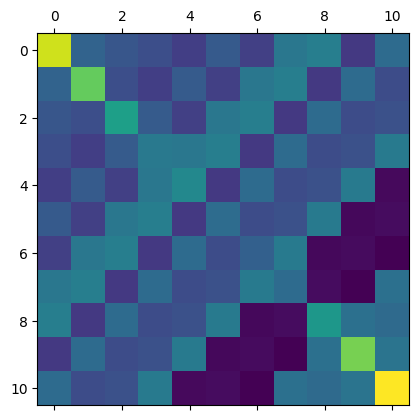

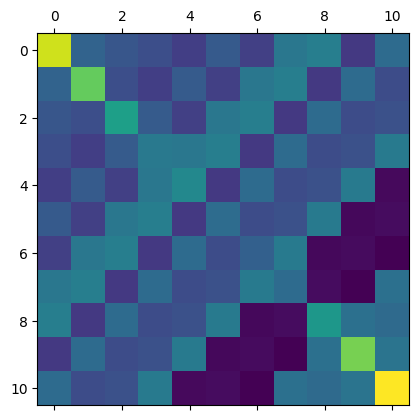

In [119]:
# The propagator after optimization and theoretical are very similar
plt.matshow(np.abs(W_plus[1] - np.eye(N_omega)))
plt.matshow(np.abs(opt_Z_W_plus_dagger[1] - np.eye(N_omega)))

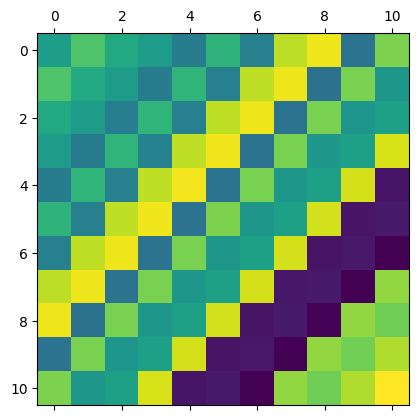

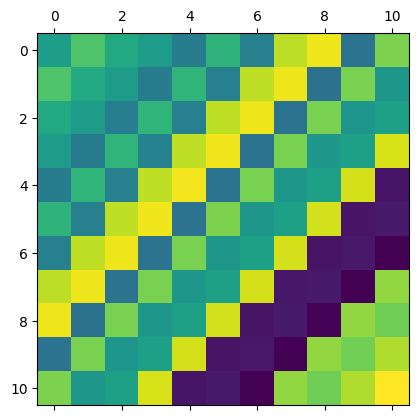

In [120]:
# The W_plus dagger W_plus of optimized and theoretical are almost identical
plt.matshow(np.real(opt_W_plus_dagger_W_plus[1] - np.eye(N_omega)))
plt.matshow(np.real(W_plus[1].conj().T@W_plus[1] - np.eye(N_omega)))

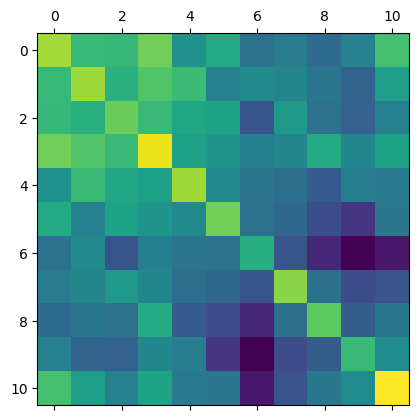

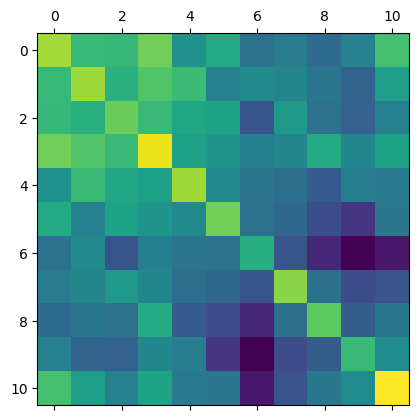

In [121]:
# The J matrix is almost identical in 
plt.matshow(np.real(opt_Z_J_dagger))
plt.matshow(np.real(J))

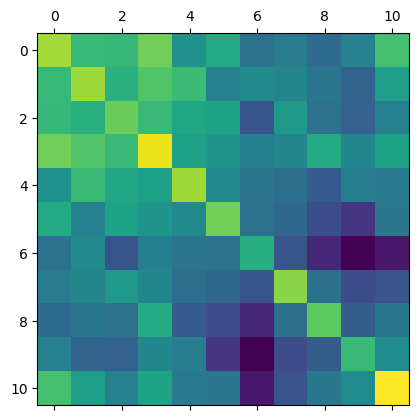

In [122]:
# The SDR also spots that J W_plus_zero dagger is J
plt.matshow(np.real(opt_J_W_plus_dagger[0]))

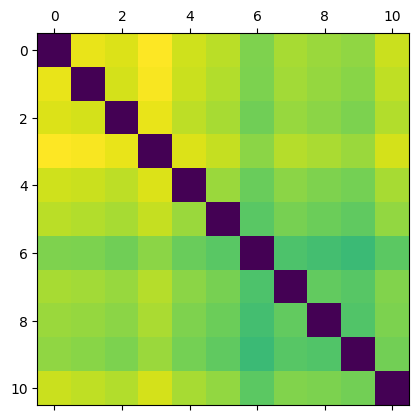

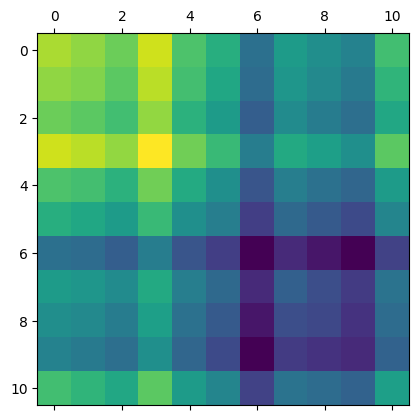

In [123]:
# J dagger J is very different tho, as if every other matrices can be driven to their theoretical value, but the J dagger J no.
plt.matshow(np.real(opt_J_dagger_J - np.diag(np.diag(opt_J_dagger_J))))
plt.matshow(np.real(J.conj().T@J))

In [124]:
# Comparison with Frobenius norm
print("Difference between J matrices: ", np.trace((opt_Z_J_dagger - J).conj().T@(opt_Z_J_dagger - J)))
print("Difference between W_plus matrices: ", np.trace((opt_Z_W_plus_dagger[1] - W_plus[1]).conj().T@(opt_Z_W_plus_dagger[1] - W_plus[1])))
print("Difference between W_minus matrices: ", np.trace((opt_Z_W_minus_dagger[1] - W_minus[1]).conj().T@(opt_Z_W_minus_dagger[1] - W_minus[1])))
print("Difference between W_plus dagger W_plus matrices: ", np.trace((opt_Z_W_plus_dagger[1].conj().T@opt_Z_W_plus_dagger[1] - W_plus[1].conj().T@W_plus[1]).conj().T@(opt_Z_W_plus_dagger[1].conj().T@opt_Z_W_plus_dagger[1] - W_plus[1].conj().T@W_plus[1])))
print("Difference between W_plus dagger W_plus matrices: ", np.trace((opt_Z_W_minus_dagger[1].conj().T@opt_Z_W_minus_dagger[1] - W_minus[1].conj().T@W_minus[1]).conj().T@(opt_Z_W_minus_dagger[1].conj().T@opt_Z_W_minus_dagger[1] - W_minus[1].conj().T@W_minus[1])))

Difference between J matrices:  (5.712204938151548e-13+0j)
Difference between W_plus matrices:  (2.4558589032984227e-09+0j)
Difference between W_minus matrices:  (3.3286685176423933e-09+0j)
Difference between W_plus dagger W_plus matrices:  (5.058002503178066e-09+0j)
Difference between W_plus dagger W_plus matrices:  (8.491276707670562e-09+0j)


In [125]:
# Frobenius norm of propagators
print("Norm of W_plus: ", np.trace(W_plus[1].conj().T@W_plus[1]))
print("Norm of W_minus: ", np.trace(W_minus[1].conj().T@W_minus[1]))
print("Norm of J: ", np.trace(J.conj().T@J))

Norm of W_plus:  (11.07797195874301+0j)
Norm of W_minus:  (10.929393306242279+0j)
Norm of J:  (2.273883212371679e-06+0j)
